In [1]:
!pip install transformers
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification
import numpy as np
import pandas as pd
import re

from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, SimpleRNN,LSTM, Activation
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
train = pd.read_csv(r"./Datasets/train_text_emoji_clean.csv")
test = pd.read_csv(r"./Datasets/test_text_emoji_clean.csv")
valid = pd.read_csv(r"./Datasets/valid_text_emoji_clean.csv")

In [3]:
def process(sen):
  if ":" in sen:
    sentence =sen[sen.index(":")+1:]
    return sentence
  return sen

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

#Pre-processing
#train["tweets"] = train["tweets"].apply(process)
#train["tweets"] = test["tweets"].apply(process)

train["tweets"] = train["tweets"].apply(preprocess_text)
test["tweets"] = test["tweets"].apply(preprocess_text)
valid['tweets'] = valid['tweets'].apply(preprocess_text)

X_train = train['tweets']
Y_train = train['labels']

X_test = test['tweets']
Y_test = test['labels']

X_valid = valid['tweets']
Y_valid = valid['labels']

In [4]:
X_train.values

array(['school is so dead o my god',
       'lol ive been told mine is worse than yours but i dont believe that',
       'im excited to hear them that shit is going rattle your soul', ...,
       'yeah you kinda do', 'nothing wit youuuu raymundo',
       'dont be that person who parks right next to me when theres a crap load of parking on the other side'],
      dtype=object)

In [5]:
possible_labels = train.labels.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11}

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [7]:
encoded_data_train = tokenizer.batch_encode_plus(
    X_train.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_valid.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(Y_train.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(Y_valid.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\17251\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [8]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [9]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=12,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 64

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [19]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

C:\Users\17251\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
epochs = 1

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [33]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}')
        print(f'Accuracy rate: {len(y_preds[y_preds==label])/len(y_true)}\n')

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [24]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [25]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), '../data_volume/finetuned_BERT.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/827 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.016557608723208
Validation loss: 2.0321387001688445
F1 Score (Weighted): 0.2782994342579796


In [79]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=12,
                                                      output_attentions=True,
                                                      output_hidden_states=True)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [80]:
model.load_state_dict(torch.load('../data_volume/finetuned_BERT.model', map_location=device))

<All keys matched successfully>

In [28]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [34]:
accuracy_per_class(predictions, true_vals)

Class: 0
Accuracy: 391/1782
Accuracy rate: 0.21941638608305275

Class: 1
Accuracy: 112/1429
Accuracy rate: 0.07837648705388384

Class: 2
Accuracy: 565/1172
Accuracy rate: 0.48208191126279865

Class: 3
Accuracy: 271/1228
Accuracy rate: 0.22068403908794787

Class: 4
Accuracy: 159/556
Accuracy rate: 0.28597122302158273

Class: 5
Accuracy: 186/749
Accuracy rate: 0.24833110814419226

Class: 6
Accuracy: 296/807
Accuracy rate: 0.3667905824039653

Class: 7
Accuracy: 907/1840
Accuracy rate: 0.49293478260869567

Class: 8
Accuracy: 279/591
Accuracy rate: 0.4720812182741117

Class: 9
Accuracy: 166/1715
Accuracy rate: 0.0967930029154519

Class: 10
Accuracy: 494/1037
Accuracy rate: 0.476374156219865

Class: 11
Accuracy: 133/575
Accuracy rate: 0.23130434782608697



['😂', '😭', '😍', '🙄', '❤', '😊', '😩', '🤔', '😘', '🏽', '💯', '🙃']

['😂' '😭' '😍' '🙄' '❤' '😊' '😩' '🤔' '😘' '🏽' '💯' '🙃']
sentence is: also who wouldve thought that will griggs on fire would be the anthem of the euros everyones singing it , prediction: 7, label: 0
sentence is: you now going to cos , prediction: 7, label: 0
sentence is: who just texted edward , prediction: 7, label: 0
sentence is: you trying to be on the next episode of first take , prediction: 7, label: 0
sentence is: which one , prediction: 7, label: 0
sentence is: lol ink why ifs think im stupid , prediction: 7, label: 0
sentence is: france in paris in the ifs though , prediction: 7, label: 0
sentence is: we still be playing this , prediction: 7, label: 0
sentence is: what , prediction: 7, label: 0
sentence is: what does a key chain have to do i my , prediction: 7, label: 0
sentence is: it takes two people to have an intercourse , prediction: 7, label: 0
sentence is: theres a difference between a father amp a daddy they should of separated the two , prediction: 7, label: 0
sentence is: w

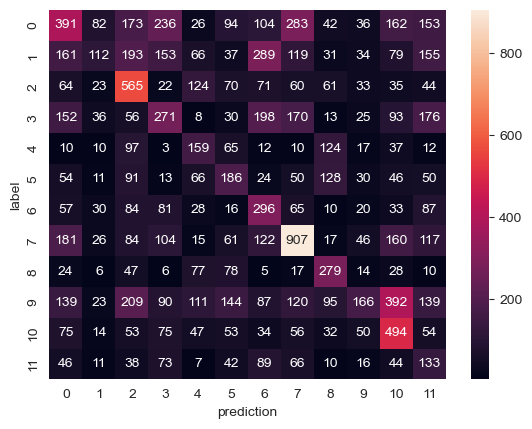

In [72]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns

preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_vals.flatten()
emojis = train["annotations"].unique()
print(emojis)
ax = sns.heatmap(confusion_matrix( labels_flat,preds_flat), annot=True, fmt="d")
ax.set(xlabel='prediction', ylabel='label')

idx=(preds_flat!=labels_flat)
for idx,equal in enumerate(idx):
    if preds_flat[idx]==7 and labels_flat[idx]==0:
        print(f"sentence is: {X_valid[idx]} , prediction: {preds_flat[idx]}, label: {labels_flat[idx]}")




['😂', '😭', '😍', '🙄', '❤', '😊', '😩', '🤔', '😘', '🏽', '💯', '🙃']

label 9🏽 and 10💯, they don't have obvious emotional meaning, so they usage might be various. So in the following discussion, we will not discuss them.

label 1😭 and 6😩, im. "i get so nervous talking to pretty girls ugh"

label 3🙄 and 0😂, "you disrespectful" "dont act like i never seen you naked". Same, different context may lead to different usage.

label 3🙄 and 1😭, both are negative emojis.  "you dont even go there yet". They true label is emoji 1. But without context, it’s also appropriate to put 3 here.

label 4❤ and 2😭, "you're the best", "it was a blessing to us all" "i'll wrap my hands around your neck so tight with love". Here, this crying emoji are used as crying for blessing or other positive emotions.

label 6😩 and  3🙄. Both negative. "all i wanna do is cuddle" "hate missing someone". Here might be usage difference. In my daily usage, emoji 6 is more appropriate to be here than emoji 3.

label 7🤔 and 0😂, "i wanna know" "who remembers this" "i meant what color". People may also use laughing to express they are curious about something. It's quite common in these days. In my opinion, using smile is a softer way to ask for something.

label 11 and 0,1,3. In some occasion, emoji 11 will be used as smiling just as emoji 0. And when expressing they are lost for words, it's same as emoji 3.


In [95]:
from bertviz import model_view,head_view
input_text = " i wonder how many pal will actually get this one"
inputs = tokenizer.encode(input_text, return_tensors='pt').to(device)
outputs = model(inputs)  # Run model
attention = outputs[-1]  # Retrieve attention from model outputs
tokens = tokenizer.convert_ids_to_tokens(inputs[0])  # Convert input ids to token strings
model_view(attention, tokens)  # Display model view

<IPython.core.display.Javascript object>